# Overview
**rtmod** is a Python repository for a collection of software tools built to support functional analysis of signaling networks. They enable to compute the functional route modulus for directed graphs that model activation, inhibition, and synergy among molecular components of signal transduction networks. The Python packages in this repository are dependent on *igraph* and *numpy*, so, if you have not already, install them by running the appropriate pip commands.

This notebook is meant to be a comprehensive overview of the main functionality of the packages in rtmod, how they work, and how to use them. We will review the methods of the **mfrpy** and **pmodpy** packages.

## Motivation
Conventional shortest-path algorithms are extremely refined and efficient. However, they are not necessarily applicable to the modeling of all types of networks. Cell signal transduction networks constitute one such example. In these instances, connections between subcomponents can be represented as directed edges, but there is no standardized representation for certain relationships between components, specifically those of conditional dependence (synergy) or inhibitory actions of some components on others. Taking these notions into account, our interest shifts from finding minimal paths from a source node to a target node to obtaining *minimal functional routes* by which a signal can travel from source to target, given these relationships between vertices in the network. One of the core aims of this project is to capture these important relationships graphically in order to better represent these important systems. In order to do this, we deal with *expanded graphs*, which are signal transduction networks that have been expanded (see below) to make computational algorithms more straightforward. We draw heavily from ideas developed by Reka Albert and colleagues at Pennsylvania State University and by Nathan Albin, Pietro Poggi-Corradini, and colleagues at Kansas State University, who have layed much of the theoretical groundwork for these concepts.

### Synergy
A regular (activating) connection between two components of a signal transduction network can be represented by a directed edge between two nodes on the graph of the network. But how can we capture the fact that some components are only activated when two (or more) of its predecessors are activated in tandem? This is where the concept of synergy comes in. When the activation of a component is conditionally dependent on the simultaneous activation of several other components, the component's corresponding node on the graph is said to have a synergistic set of predeccessors consisting of precisely the nodes of the conditional components. Alternatively, we can say that the edges between these nodes have the same synergy value, which is the method by which this charecteristic is employed in the actual algorithm. 

### Inhibition
It is often the case in cellular networks that one component inhibits the activation of another. This too, can be captured graphically. A certain node can be inhibited by one of its predeccessors, so instead of drawing an activating edge between them we might want to consider calling the edge between them inhibitory. More generally, we can assign every edge a sign +1 or -1 that distinguishes it as activatory or inhibitory.

### Theoretical Work
How do we represent attributes such as synergy and inhibition graphically? One way is by adding new conventions, such as dashed and barred edges, but this is largely unintuitive and can lead to ambiguity and confusion. Instead, we can transform the entire graph with the appropriate attributes into an "expanded" version of itself - a directed graph with only activating edges but with no ambiguity as to what components are synergistic and which are inhibitory. This is done by introducing new vertices: composite and inhibitory nodes. Composite nodes link a conditionally dependent node to its synergistic set of predecessors, while inhibitory nodes are activated when one component inhibits another. For example, if A inhibits B, we can also say that NOT A activates B AND A activates NOT B. By employing these tricks we can circumvent possible confusion and create programs which are capable of working with these notions.

### Empirical Networks
To illustrate its functionality, we apply both packages to a network from the real world: ...

## mfrpy
**mfrpy** is a package for calculating the minimal functional routes of a given graph. 

### igraph objects
The **igraph** package encodes graphs as operable Python objects. Edges and vertices are encoded in lists, making it possible to iteritavely attach attributes to each element based on certain criteria. To familiarize ourselves with the format, we can initialize an example graph:


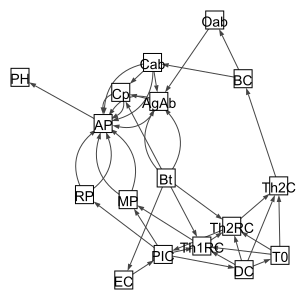

In [2]:
from igraph import *
g = Graph.Read_GraphML("bordetellaeGraph.xml")
g.vs["name"] = g.vs["id"]
g.vs["label"] = g.vs["name"]
plot(g, vertex_size = 18, vertex_shape = "square", edge_arrow_size = 0.5, vertex_color = "white", bbox=(0, 0, 300, 300))

Our test graph is a directed cyclic graph on 6 labeled vertices. Given prior knowledge of the network this graph represents, we can include synergy and inhibition quite easily by attaching the appropriate attributes to the edge sequence. Here, synergistic edges are colored blue.

edge syn inhibitory
Bt -> EC 0.0 False
Bt -> Th2RC 0.0 True
Bt -> Th1RC 0.0 True
EC -> PIC 1.0 False
Th2RC -> PIC 1.0 True
PIC -> DC 0.0 False
DC -> T0 0.0 False
Th1RC -> Th2RC 2.0 True
DC -> Th2RC 2.0 False
T0 -> Th2RC 2.0 False
T0 -> Th1RC 3.0 False
PIC -> Th1RC 3.0 False
DC -> Th1RC 3.0 False
Th2RC -> Th2C 4.0 False
T0 -> Th2C 4.0 False
DC -> Th2C 4.0 False
PIC -> MP 0.0 False
Th1RC -> MP 0.0 False
Th2C -> BC 0.0 False
BC -> Cab 0.0 False
BC -> Oab 0.0 False
Bt -> AgAb 5.0 False
Cab -> AgAb 5.0 False
Bt -> AgAb 5.0 False
Oab -> AgAb 6.0 False
PIC -> RP 0.0 False
Bt -> Cp 0.0 False
Cab -> Cp 7.0 False
AgAb -> Cp 7.0 False
AgAb -> AP 8.0 False
RP -> AP 8.0 False
AgAb -> AP 8.0 False
MP -> AP 9.0 False
Cp -> AP 10.0 False
Cab -> AP 10.0 False
RP -> AP 8.0 False
Cab -> AP 10.0 False
Cp -> AP 10.0 False
MP -> AP 9.0 False
AP -> PH 0.0 False


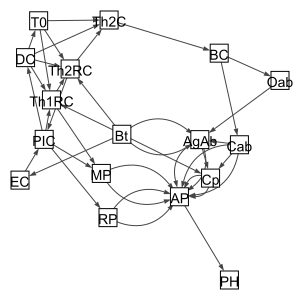

In [3]:
print("edge", "syn", "inhibitory")
for edge in g.get_edgelist():
    print(g.vs[edge[0]]["name"], "->", g.vs[edge[1]]["name"], g.es[g.get_edgelist().index(edge)]["synergy"], bool(g.es[g.get_edgelist().index(edge)]["inhibition"]))
    
#g.es.select(_source_in=[1,2], _target_in=[3])["color"] = "blue"
plot(g, vertex_size = 18, vertex_shape = "square", edge_arrow_size = 0.5, vertex_color = "white", bbox=(0, 0, 300, 300))

### update_expand.py

This is a collection of methods for generating boolean update tables for the input graph, and converting these input tables into an expanded graph with composite nodes and logical NOT nodes to capture the behaviors of synergistic and inhibitory edges. We first obtain an update table with a zero-order logical expression for every node in the graph. The source node will always have an empty expressions since it lacks predecessors:

In [4]:
from mfrpy import update_expand
table = update_expand.updates(g, g.es["synergy"], g.es["inhibition"], 1)

Bt = 
EC = Bt
Th1RC = (T0&PIC&DC)|~Bt
Th2RC = (~Th1RC&DC&T0)|~Bt
PIC = (EC&~Th2RC)
DC = PIC
T0 = DC
Th2C = (Th2RC&T0&DC)
Cab = BC
Oab = BC
AgAb = (Bt&Cab)|(Bt&Oab)
Cp = (Cab&AgAb)|Bt
RP = PIC
AP = (AgAb&RP)|(AgAb&MP)|(Cp&Cab&RP)|(Cab&Cp&MP)
PH = AP
MP = Th1RC|PIC
BC = Th2C
~Th1RC = (Bt&~DC)|(Bt&~PIC)|(Bt&~T0)
~Th2RC = (Bt&Th1RC)|(Bt&~DC)|(Bt&~T0)
~PIC = Th2RC|~EC


We can now use this table to accurately expand our graph with the considerations of synergy and inhibition. Here, '~' is the logical NOT, whereas '&' and '|' are the logical AND and OR respectively. The drawback of doing this process graph-theoretically is the challenge of handling edges which have both attributes, as it is not always clear which expansion to perform first. By computing via the update table, there is no ambiguity and both attributes are expanded in tandem. We can now expand the test graph by running

In [10]:
exp_g = update_expand.expand(g, table, 1)

IGRAPH DN-- 41 71 --
+ attr: composite (v), label (v), name (v)
+ edges (vertex names):
Bt->EC, T0->~Cab, PIC->~Cab, DC->~Cab, ~Cab->Th1RC, ~Bt->Th1RC, ~Th1RC->~AgAb,
DC->~AgAb, T0->~AgAb, ~AgAb->Th2RC, ~Bt->Th2RC, EC->~RP, ~Th2RC->~RP,
~RP->PIC, PIC->DC, DC->T0, Th2RC->~PH, T0->~PH, DC->~PH, ~PH->Th2C, BC->Cab,
BC->Oab, Bt->~BC, Cab->~BC, ~BC->AgAb, Bt->c2, Oab->c2, c2->AgAb, Cab->c4,
AgAb->c4, c4->Cp, Bt->Cp, PIC->RP, AgAb->c6, RP->c6, c6->AP, AgAb->c8, MP->c8,
c8->AP, Cp->c10, Cab->c10, RP->c10, c10->AP, Cab->c11, Cp->c11, MP->c11,
c11->AP, AP->PH, Th1RC->MP, PIC->MP, Th2C->BC, Bt->c12, ~DC->c12, c12->~Th1RC,
Bt->c13, ~PIC->c13, c13->~Th1RC, Bt->c14, ~T0->c14, c14->~Th1RC, Bt->c15,
Th1RC->c15, c15->~Th2RC, Bt->c16, ~DC->c16, c16->~Th2RC, Bt->c17, ~T0->c17,
c17->~Th2RC, Th2RC->~PIC, ~EC->~PIC
['Bt', 'EC', 'Th1RC', 'Th2RC', 'PIC', 'DC', 'T0', 'Th2C', 'Cab', 'Oab', 'AgAb', 'Cp', 'RP', 'AP', 'PH', 'MP', 'BC', '~Bt', '~EC', '~Th1RC', '~Th2RC', '~PIC', '~DC', '~T0', '~Cab', '~AgAb', '~RP'

### sgmfr.py

This is a method for calculating the minimal functional routes of an expanded graph provided by **update_expand**. The method uses a top-down subgraph-growing algorithm to generate minimal functional routes in the expanded graph. starting from a target node, the algorithm examines its predecessors. If there are no composite nodes, it proceeds by adding predecessors one at a time until it reaches the source node, at which point it will pursue a different chain of predecessors, much like a normal shortest-path algorithm. However, if it encounters a composite node, the method appends all of the nodes predecessors as one synergistic set in the minimal functional route. To avoid redundancy that may occur from cyclic graphs, cycles are cleaved after all minimal functional routes are generated.

## pmodpy

*pmodpy* is a Python implementation of the graph modulus developed by Albin, Poggi-Corradini, and colleagues at Kansas State University. This is an analogue to mathematical graphs of the classical modulus defined on families of curves in a domain of the complex plane, and it is parameterized by the exponent $p$ of a distance norm.

An important theoretical contribution of the graph modulus is that its value on the family of walks between two nodes in a  graph $G$ unifies three common conceptions of distance on garphs: the maximum flow / minimum cut weight ($p = 1$), the resistance distance ($p = 2$), and the shortest path length ($p = \infty$). Its calculation also induces both an extremal density function on the edges of $G$ and an optimal probability mass function on the family of objects (e.g. walks) of interest.

These can be understood as measures of the importance of each edge or object to the task that defines the family, e.g. connecting two nodes or connecting all nodes of the graph. Because our interest is to understand signal transduction through the components of an intracellular signaling network, our objects of interest are functional routes.

Our implementation can compute the modulus for walks (whose minimal objects are paths), spanning subgraphs (whose minimal objects are spanning trees), and functional routes (for graphs with inhibition and/or synergy). Our first goal is to compare the insights gained and predictions made by signal transduction network analysis using minimal paths (a conventional approach) versus minimal functional routes.